<a href="https://colab.research.google.com/github/MariAgudelo2/Proyecto_KAGGLE/blob/main/04%20-%20modelo%20con%20preprocesado%20y%20Random%20Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 720MB/s]


In [ ]:
!unzip udea*.zip > /dev/null

In [ ]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185238 test.csv
   692501  10666231 143732437 train.csv
  1286075  15528571 207634348 total


# Preprocesamiento

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
class RandomForestPreprocessing:

  def __init__(self, csv_file):
    self.z_copy = csv_file.copy()
    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test = None
    self.le = None

  def inspect_data(self):
    print("Inspeccionando los datos...")
    self.z_copy.head()
    self.z_copy.info()
    self.z_copy.isnull().sum()

  def clean_data(self):
    print("Iniciando limpieza de datos...")
    self.clean_privadolibertad_column()
    self.clean_tiene_columns()
    self.clean_valormatricula_column()
    self.clean_educacionpadres_columns()
    self.clean_estratovivienda_column()
    self.clean_horassemanatrabaja_column()
    self.clean_agrupar_programas_por_area()
    self.onehot_encoding_departamentos()

    print("Limpieza terminada")
    print(f"Shape final: {self.z_copy.shape}")

  def clean_privadolibertad_column(self):
    map_tiene = {'S': 1, 'N': 0}
    self.z_copy['E_PRIVADO_LIBERTAD'] = self.z_copy['E_PRIVADO_LIBERTAD'].map(map_tiene)

  def clean_tiene_columns(self):
    self.z_copy = self.z_copy.drop(['F_TIENEINTERNET.1'], axis=1)
    cols_tiene = [
        'F_TIENEINTERNET', 'F_TIENELAVADORA',
        'F_TIENEAUTOMOVIL', 'F_TIENECOMPUTADOR',
        'E_PAGOMATRICULAPROPIO'
    ]

    for col in cols_tiene:
        self.z_copy[col] = self.z_copy[col].fillna('No_info')

    map_tiene = {'Si': 1, 'No': 0, 'No_info': -1}

    for col in cols_tiene:
        self.z_copy[col] = self.z_copy[col].map(map_tiene)

  def clean_valormatricula_column(self):

    def convertir_rango_a_numero(valor):
      import re
      import unicodedata

      if pd.isna(valor):
          return np.nan

      texto = str(valor).lower()
      texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')

      if "no pago" in texto:
          return 0.0

      patrones = re.findall(r'(\d+\.?\d*)\s*(millon(?:es)?|mil)?', texto)
      numeros = []

      for num, unidad in patrones:
          n = float(num)
          if "millon" in unidad:
              n *= 1_000_000
          elif "mil" in unidad:
              n *= 1_000
          numeros.append(n)

      # Caso 'Entre X y menos de Y'
      if len(numeros) == 2:
          return np.mean(numeros)

      # Caso 'Menos de X'
      if "menos de" in texto and len(numeros) == 1:
          return numeros[0] / 2

      # Caso 'Más de X', asumimos +10% del umbral
      if "mas de" in texto and len(numeros) == 1:
          return numeros[0] * 1.1

      return np.nan

    self.z_copy['E_VALORMATRICULAUNIVERSIDAD'] = self.z_copy['E_VALORMATRICULAUNIVERSIDAD'].apply(convertir_rango_a_numero)
    mediana = self.z_copy['E_VALORMATRICULAUNIVERSIDAD'].median()
    self.z_copy['E_VALORMATRICULAUNIVERSIDAD'] = self.z_copy['E_VALORMATRICULAUNIVERSIDAD'].fillna(mediana)

  def clean_educacionpadres_columns(self):
    from sklearn.preprocessing import OrdinalEncoder

    orden_educacion = [
        'sin info',
        'Primaria incompleta',
        'Primaria completa',
        'Secundaria (Bachillerato) incompleta',
        'Secundaria (Bachillerato) completa',
        'Técnica o tecnológica incompleta',
        'Técnica o tecnológica completa',
        'Educación profesional incompleta',
        'Educación profesional completa',
        'Postgrado'
    ]

    cols_to_clean = ['F_EDUCACIONMADRE', 'F_EDUCACIONPADRE']
    for col in cols_to_clean:
        self.z_copy[col] = self.z_copy[col].replace(['Ninguno', 'No Aplica', 'No sabe'], 'sin info')
        self.z_copy[col] = self.z_copy[col].fillna('sin info')

    # Creamos el codificador para ambas columnas, asegurando que 'sin info' sea manejado
    # El parámetro 'categories' debe ser una lista de listas, una por cada columna
    encoder = OrdinalEncoder(categories=[orden_educacion, orden_educacion])

    # Aplicamos la codificación a ambas columnas al mismo tiempo
    self.z_copy[cols_to_clean] = encoder.fit_transform(self.z_copy[cols_to_clean])

  def clean_estratovivienda_column(self):
    self.z_copy['F_ESTRATOVIVIENDA'] = (
    self.z_copy['F_ESTRATOVIVIENDA']
    .astype(str)
    .replace(r'Estrato\s*(\d+)', r'\1', regex=True)
    .replace('Sin Estrato', 0)
    )

    self.z_copy['F_ESTRATOVIVIENDA'] = pd.to_numeric(self.z_copy['F_ESTRATOVIVIENDA'], errors='coerce')

    moda_estrato = self.z_copy['F_ESTRATOVIVIENDA'].mode()[0]
    self.z_copy['F_ESTRATOVIVIENDA'] = self.z_copy['F_ESTRATOVIVIENDA'].fillna(moda_estrato)

    self.z_copy['F_ESTRATOVIVIENDA'] = self.z_copy['F_ESTRATOVIVIENDA'].astype(int)

  def clean_horassemanatrabaja_column(self):
    mapa_horas = {
    '0': 0,
    'Menos de 10 horas': 5,
    'Entre 11 y 20 horas': 15,
    'Entre 21 y 30 horas': 25,
    'Más de 30 horas': 35
    }

    self.z_copy['E_HORASSEMANATRABAJA'] = self.z_copy['E_HORASSEMANATRABAJA'].replace(mapa_horas)
    self.z_copy['E_HORASSEMANATRABAJA'] = pd.to_numeric(self.z_copy['E_HORASSEMANATRABAJA'], errors='coerce')

    mediana_horas = self.z_copy['E_HORASSEMANATRABAJA'].median()
    self.z_copy['E_HORASSEMANATRABAJA'] = self.z_copy['E_HORASSEMANATRABAJA'].fillna(mediana_horas)

  def clean_agrupar_programas_por_area(self):
    # Agrupa los programas académicos en áreas generales

    areas_dict = {
        'INGENIERIA': ['INGENIER', 'INGENER'],
        'SALUD': ['MEDICINA', 'ENFERMERIA', 'ODONTOLOGIA', 'FISIOTERAPIA',
                  'TERAPIA', 'NUTRICION', 'OPTOMETRIA', 'FONOAUDIOLOGIA',
                  'INSTRUMENTACION QUIRURGICA', 'BACTERIOLOGIA'],
        'ADMINISTRACION': ['ADMINISTR', 'GESTION', 'GERENCIA', 'NEGOCIOS',
                           'COMERCIO', 'FINANZAS', 'MERCADEO', 'MARKETING',
                           'LOGISTICA', 'BANCA'],
        'EDUCACION': ['LICENCIATURA', 'PEDAGOGIA', 'EDUCACION'],
        'ARTES': ['ARTE', 'DISEÑO', 'DISE', 'MUSICA', 'DANZA', 'TEATRO',
                  'CINE', 'FOTOGRAFIA', 'AUDIOVISUAL'],
        'CIENCIAS_SOCIALES': ['DERECHO', 'PSICOLOGIA', 'SOCIOLOGIA',
                              'TRABAJO SOCIAL', 'ANTROPOLOGIA', 'FILOSOFIA',
                              'CIENCIA POLITICA', 'RELACIONES INTERNACIONALES'],
        'COMUNICACION': ['COMUNICACION', 'PERIODISMO', 'PUBLICIDAD'],
        'CIENCIAS_EXACTAS': ['MATEMATICA', 'FISICA', 'QUIMICA', 'BIOLOGIA',
                             'ESTADISTICA', 'ASTRONOMIA'],
        'AGRONOMIA': ['AGRO', 'VETERINARIA', 'ZOOTECNIA', 'PECUARIA'],
        'ARQUITECTURA': ['ARQUITECTURA', 'URBANISMO', 'CONSTRUCCION']
    }

    def clasificar_programa(programa):
        programa_upper = str(programa).upper()

        for area, keywords in areas_dict.items():
            if any(keyword in programa_upper for keyword in keywords):
                return area

        return 'OTRAS'

    self.z_copy['AREA_CONOCIMIENTO'] = self.z_copy['E_PRGM_ACADEMICO'].apply(clasificar_programa)

    # One-hot encoding para áreas
    area_dummies = pd.get_dummies(
        self.z_copy['AREA_CONOCIMIENTO'],
        prefix='area',
        drop_first=True
    ).astype(int)

    self.z_copy = pd.concat([self.z_copy, area_dummies], axis=1)
    print(f"Programas agrupados en {self.z_copy['AREA_CONOCIMIENTO'].nunique()} áreas")

  def onehot_encoding_departamentos(self):
    depto_dummies = pd.get_dummies(
        self.z_copy['E_PRGM_DEPARTAMENTO'],
        prefix='depto',
        drop_first=True
    ).astype(int)

    self.z_copy = pd.concat([self.z_copy, depto_dummies], axis=1)

  def create_features(self):
    # Educación promedio de los padres
    self.z_copy['F_EDUCACION_PROMEDIO_PADRES'] = (self.z_copy['F_EDUCACIONPADRE'] + self.z_copy['F_EDUCACIONMADRE']) / 2

    # Indicador de recursos en el hogar (suma de dispositivos)
    self.z_copy['F_RECURSOS_HOGAR'] = (
        self.z_copy['F_TIENEINTERNET'] +
        self.z_copy['F_TIENECOMPUTADOR'] +
        self.z_copy['F_TIENELAVADORA'] +
        self.z_copy['F_TIENEAUTOMOVIL']
    )

    # Trabajo vs estudio (más horas = menos tiempo para estudiar)
    self.z_copy['E_CARGA_TRABAJO'] = self.z_copy['E_HORASSEMANATRABAJA'] / 40

    print(f"Features creadas. Shape actual: {self.z_copy.shape}")

  def apply_random_forest(self):
    print("Entrenando al modelo (Random Forest)...")
    self.le = LabelEncoder()
    y = self.le.fit_transform(self.z_copy['RENDIMIENTO_GLOBAL'])

    X = self.z_copy.drop(['ID', 'RENDIMIENTO_GLOBAL', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'AREA_CONOCIMIENTO'], axis=1)

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set size: {self.X_train.shape}")
    print(f"Test set size: {self.X_test.shape}")
    print(f"\nClass distribution in training set:")
    unique, counts = np.unique(self.y_train, return_counts=True)
    for cls, cnt in zip(unique, counts):
        print(f"  Class {self.le.classes_[cls]}: {cnt} ({cnt/len(self.y_train)*100:.2f}%)")


    rf_model = RandomForestClassifier(
    n_estimators=300,              # Más árboles
    max_depth=None,                # Sin límite (deja que crezca)
    min_samples_split=5,           # Más flexible
    min_samples_leaf=2,            # Evita overfitting
    max_features='sqrt',           # Randomness adicional
    class_weight='balanced',       # Para clases balanceadas
    random_state=42,
    n_jobs=-1
    )

    rf_model.fit(self.X_train, self.y_train)
    y_pred_rf = rf_model.predict(self.X_test)

    print("\n--- Resultados Random Forest ---")
    print(f"Accuracy: {accuracy_score(self.y_test, y_pred_rf):.4f}")
    print("\nClassification Report:")
    print(classification_report(self.y_test, y_pred_rf,
                              target_names=self.le.classes_))

    # Matriz de confusión RF
    cm_rf = confusion_matrix(self.y_test, y_pred_rf)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
                xticklabels=self.le.classes_, yticklabels=self.le.classes_)
    plt.title('Matriz de Confusión - Random Forest')
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.tight_layout()
    plt.show()

# Entrenamiento del modelo

shape of loaded dataframe (692500, 21)
Inspeccionando los datos...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           692500 non-null  int64  
 1   PERIODO_ACADEMICO            692500 non-null  int64  
 2   E_PRGM_ACADEMICO             692500 non-null  object 
 3   E_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   E_VALORMATRICULAUNIVERSIDAD  686213 non-null  object 
 5   E_HORASSEMANATRABAJA         661643 non-null  object 
 6   F_ESTRATOVIVIENDA            660363 non-null  object 
 7   F_TIENEINTERNET              665871 non-null  object 
 8   F_EDUCACIONPADRE             669322 non-null  object 
 9   F_TIENELAVADORA              652727 non-null  object 
 10  F_TIENEAUTOMOVIL             648877 non-null  object 
 11  E_PRIVADO_LIBERTAD           692500 non-null  obje

/tmp/ipython-input-3069514671.py:147: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.z_copy['E_HORASSEMANATRABAJA'] = self.z_copy['E_HORASSEMANATRABAJA'].replace(mapa_horas)


Programas agrupados en 11 áreas
Limpieza terminada
Shape final: (692500, 61)
Features creadas. Shape actual: (692500, 64)
Entrenando al modelo (Random Forest)...
Training set size: (554000, 59)
Test set size: (138500, 59)

Class distribution in training set:
  Class alto: 140495 (25.36%)
  Class bajo: 138390 (24.98%)
  Class medio-alto: 137295 (24.78%)
  Class medio-bajo: 137820 (24.88%)

--- Resultados Random Forest ---
Accuracy: 0.4057

Classification Report:
              precision    recall  f1-score   support

        alto       0.52      0.60      0.55     35124
        bajo       0.43      0.52      0.47     34597
  medio-alto       0.31      0.24      0.27     34324
  medio-bajo       0.31      0.27      0.29     34455

    accuracy                           0.41    138500
   macro avg       0.39      0.40      0.39    138500
weighted avg       0.39      0.41      0.39    138500



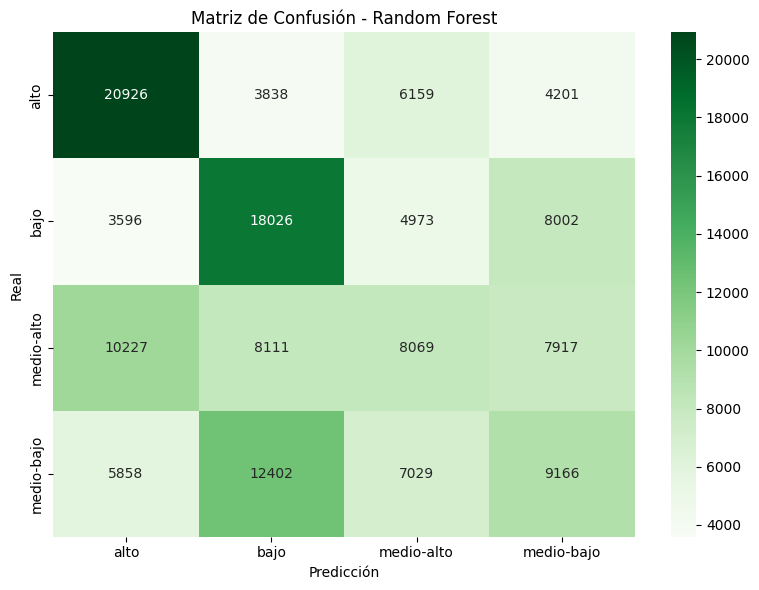

In [ ]:
z = pd.read_csv("train.csv")
print ("shape of loaded dataframe", z.shape)

preprocessor = RandomForestPreprocessing(z)
preprocessor.inspect_data()
preprocessor.clean_data()
preprocessor.create_features()
preprocessor.apply_random_forest()